# Der diskrete Bayes-Filter zum Tracken eines Roboterfahrzeugs, Teil 2
17.10.2022, S. Mack

Nachfolgend werden aus dem voran gegangenen Teil 1 die nötigen Importe und Funktionsdefinitionen wiederholt.

In [1]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

def barPlot(belief_data, y_lim=1.1): # helper function to plot
    plt.grid(zorder=0)
    plt.ylim(0,y_lim)
    x = np.arange(len(belief_data))
    plt.xticks(x)
    plt.bar(x, belief_data, color='C0',zorder=3) # zorder to have bars in front of grid

def twoBarPlots(plot_one, title_one, plot_two, title_two, y_lim=1.1): # helper function to plot
    x = np.arange(len(plot_one))
    plt.figure(figsize=(14,4))

    plt.subplot(121) # First of two plots side by side
    plt.grid(zorder=0)
    plt.ylim(0,y_lim)
    plt.xticks(x)
    plt.title(title_one)
    plt.bar(x,plot_one,color='C0',zorder=3)

    plt.subplot(122) # Second of two plots side by side
    plt.grid(zorder=0)
    plt.ylim(0,y_lim)
    plt.xticks(x)
    plt.title(title_two)
    plt.bar(x,plot_two,color='C0',zorder=3)
    
def lh_hallway(hallway, z, z_prob):
    """Compute likelihood that a binary door measurement matches positions in the hallway.
    z = 1 stands for an open und z = 0 for a closed door detected. z_prob is the confidence
    level of the door measurement. Each element of the array hallway represents a door position.
    An element with value 0 indicates an open door."""    
    try: # This will catch the case if there is no measurement error
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError: # Give error report
        scale = 1e8
    likelihood = np.ones(len(hallway))
    # only state of likelihood equal to z will be scaled
    likelihood[hallway==z] *= scale # [hallway==z] selects index of position z
    return likelihood

def update(likelihood, prior):
    """Compute posterior based on likelihood and prior."""
    posterior = (likelihood * prior)/sum(likelihood * prior)
    return (posterior)

## Allgemeine Rechnung mit verrauschten Positionsannahmen und verrauschten Bewegungmesswerten

### Die Faltungsfunktion

In dem exemplarischen Beispiel des vorherigen Abschnitts war der maximale Fehler der Bewegungsmessung +/- eine Position. Dies soll nun allgemeiner gefasst werden. Nachfolgend wird aus der Funktion ``predict_move()`` die Funktion ``predict_move_convolution()`` entwickelt, die auch größere Messunsicherheiten wie zwei oder drei Türpositionen berücksichtigt. Es ist aber nach wie vor der Fall, dass *nur Bewegungsschritte, jedoch keine neuen Türmessschritte betrachtet werden*.    
Wie schon erwähnt, ist die mathematische Operation der *Faltung* hierfür optimal geeignet. Bei einer Faltung wird eine Funktion durch eine anderen Funktion modifiziert. Im hier vorliegenden Fall wird die Wahrscheinlichkeitsverteilung der Fahrzeugposition durch die Funktion der Fehlerverteilung des Bewegungssensors modifiziert.  
**Die Implementierung der Funktion ``predict_move()`` oben ist im Ergebnis tatsächlich schon eine Faltung.**  

Sie ist bloß nur formal nicht als solche leicht zu erkennen. Eine Faltung ist definiert als

$$ (f \ast g) (t) = \int_0^t \!f(\tau) \, g(t-\tau) \, \mathrm{d}\tau$$

wobei die Schreibweise $f\ast g$ bedeutet "f wird mit g gefaltet".  

>**Achtung: Falten bedeutet nicht Multiplizieren:**  $ f\ast g \neq f \cdot g$. 

Bei der Faltung verschwindet die Variable $\tau$ durch die Integration. Die Variable $t$ ist so etwas wie ein Aufpunkt für das Falten. Mann kann sich die Faltungsoperation so vorstellen, dass die Funktion $g$ wíe eine Schablone über die Funktion $f$ gelegt wird, und dabei das durch die  Schablone Sichbare aufintegriert wird. Die Variable $t$ bestimmt dabei den Ort von $f$, an dem die Schablone aufgelegt wird. $\tau$ ist die Integrationsvariable, die nach erfolgter Integration verschwindet.   
In der Bildverarbeitung beispielsweise bedeutet Falten Weichzeichnen: Hier kann man sich das Falten so vorstellen, dass eine kleine Streuscheibe über das Bild gelegt wird und dieses abrastert.    

Die Definition der Faltung oben verwendet Integrale und ist daher für kontinuierliche Funktionen gedacht. In der digitalen Datenverarbeitung dreht sich Alles um diskrete Werte, die z.B. als Arrays vorliegen. Daher wird hier das Integral durch eine Summe ersetzt und die runden Klammern durch eckige Array-Klammern:

$$ (f \ast g) [t] = \sum\limits_{\tau=0}^t \!f[\tau] \, g[t-\tau]$$

Die schon verwendete Funktion `predict_move()` folgt genau dieser Gleichung - sie berechnet die Summe aus einer Folge von Multiplikationen.  

**Nochmals zum sicheren Verständnis des Grundprinzips:** Bei der Faltung wird ein Array (*Kernel* genannt) gegen ein zweites Array verschoben. Man sagt *das letztere Array wird mit dem Kernel gefaltet.*  
Der Index $t$ gibt dabei an, um wieviel die beiden Arrays gegeneinander verschoben sind. Zur Faltung werden die beiden Elemente der Arrays die sich überdecken miteinander multipliziert und dann aufaddiert.  

Genau das wird in der neuen Funktion ``predict_move_convolution()`` durchgeführt. Die Variable ``belief`` wird nun in ``pd`` umgetauft. ``pd`` steht für "Probability Distribution" (Wahrscheinlichkeitsverteilung).

In [2]:
def predict_move_convolution(pd, offset, kernel):
    N = len(pd)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

Der Code oben ist aufgrund der For-Schleife recht langsam. Viel schneller ist die Faltungs-Funktion `convolve()` aus dem ``SciPy``-Package, die schon in der ``NumPy``-Version bei dem Beispielen zum g-h-Filter für die gleitende Mittelwertbildung verwendet wurde. (Leider gibt es in der ``NumPy``-Version von  `convolve()` nicht den Modus "wrap" für die hier verwendeten "kreisförmigen" Arrays. Daher wird nachfolgend statt ``NumPy`` das Package ``SciPy`` beim Import verwendet.) Die ``pd`` muss jedoch vorher noch mit der Funktion ``np.roll()`` um den ``offset`` verschoben werden.  

Damit kann der Bewegungs-/Vorhersageschritt nun mit einer Codezeile implementiert werden:

```python
convolve(np.roll(pd, offset), kernel, mode='wrap')
```

### Anwendung der Faltung für Bewegung um einen Schritt nach Rechts

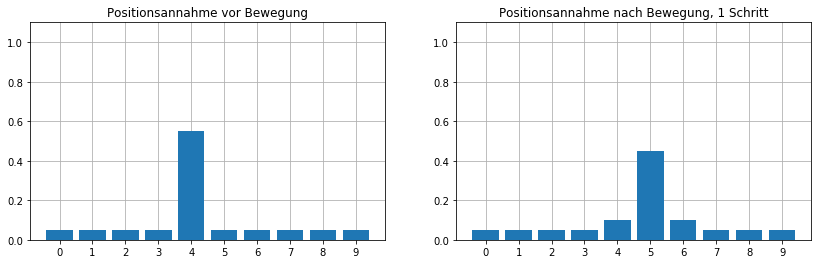

In [3]:
from scipy.ndimage.filters import convolve

def predict(pd, offset, kernel):
    prior = convolve(np.roll(pd, offset), kernel, mode='wrap')
    return prior

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict(belief, offset=1, kernel=[.1, .8, .1])
twoBarPlots(belief, 'Positionsannahme vor Bewegung', prior, 'Positionsannahme nach Bewegung, 1 Schritt')

Im Code oben wird die Vorhersage aufgrund einer gemessenen Bewegung um eine Position (``offset=1``) mit den Messunsicherheiten 10 %, 80 % und 10 % berechnet. 
Die Werte bei Index 4 und 6 der Verteilung nach der Bewegung (prior) berechnen sich zu  

$$(0.1 \times 0.05)+ (0.8 \times 0.05) + (0.1 \times 0.55) = 0.1$$  

Der Wert des Index 5 berechnet sich zu $$(0.1 \times 0.05) + (0.8 \times 0.55)+ (0.1 \times 0.05) = 0.45$$  

### Wiederholung Kerngedanken der Bewegungsvorhersage via Faltung
Sowohl die Wahrscheinlichkeitsverteilung der Position als auch der Messwert der Bewegung liegen jeweils als Array vor. Die Vorhersage erzeugt die Wahrscheinlichkeitsverteilung für den nächsten Zeitpunkt (Prior genannt) mittels einer Faltung des Bewegungsarrays mit der Wahrscheinlichkeitsverteilung zum aktuellen Zeitpunkt.   

Allgemein drückt man dieses mathematische Vorgehen mit folgender Formel aus:

$$ \bar{ \mathbf x}_{k+1} = \mathbf {\hat x}_k \ast f_{\mathbf x}(\bullet)$$

$f_x(\bullet)$ steht für die "Propagationsfunktion" des Zustands. Einfacher ausgedrückt: Sie legt fest, wie viel die Elemente des Vektors ${\hat x}_k$ sich während eines Samplingintervalls ändern. 
>Die aktuelle Wahrscheinlichkeitsverteilung der Position wird mit einer statistischen Annahme über die Bewegung *gefaltet*.

Der Index $k$ bezeichnet nun die aufeinander folgenden Iterationen bzw. Zeitpunkte. $\mathbf x$ ist fettgedruckt, denn es steht für ein Array. Die Elemente dieses Arrays sind die verschiedenen Wahrscheinlichkeiten für die unterschiedlichen Zustände (hier Türpositionen). Nach der Vorhersage wird das Array als $\mathbf {\bar x}$ und nach der Korrektur als $\mathbf {\hat x}$ bezeichnet.

## Iterationen aus Türmessungen *und* Bewegungsvorhersagen

Bisher wurde von einer willkürlichen initiale Wahrscheinlichkeitsverteilung der Position ausgegangen. Diese Verteilung wurde anschließend durch eine oder mehrere aufeinanderfolgende Vorhersagen "propagiert" oder besser gesagt "verschmiert". Jede Vorhersage berechnete sich jeweils aus einer Bewegungsmessung. Dadurch wurde die Positionsinformation immer diffuser - genau das Gegenteil, was man von einem Kalman-Filter erwartet!    

**Nun wird endlich der realistische Fall betrachtet, dass sowohl eine Türmessung als auch eine Bewegungsvorhersage pro Iteration stattfindet. Jede Vorhersage wird von einer Korrektur gefolgt, bei der eine neue Türmessung berücksichtigt wird.**  
Dieser Korrektur-Schritt *erhöht* das Wissen über die Fahrzeugposition. Ausgehend von dieser konkreteren Information wird anschließend eine Vorhersage berechnet, die dieses Wissen wieder etwas diffuser macht. Das Vorhersageergebnis wird in der nächsten Iteration jedoch wieder durch eine Korrektur mit einer Türmessung konkretisiert usw.  
Durch diesen Prozess steigt das Wissen über die Position von Iteration zu Iteration, d.h. das Fahrzeug wird Schritt für Schritt besser lokalisiert - jetzt findet eine Filterwirkung tatsächlich statt.  

**Die Iteration aus *Vorhersage* und *Korrektur* kann jetzt sofort implementiert werden, da die beiden Funktionen ``predict()`` und ``update()`` dazu schon erstellt wurden.**
Nachfolgend wird eine solche Iteration für das Fahrzeug durchgeführt. Anders als bisher wird als Startpunkt nicht die bekannte Position 0 sondern eine völlig unbekannte Position gewählt. Diese Positionsannahme hat in jedem Element den Wert 1/10 - das Fahrzeug kann überall sein. Sie stellt in der Filteriteration auch den ersten Vorhersagewert d.h. den ersten Prior da. Denn eine Gleichverteilung kann man propagieren/falten/verschmieren wie man will - sie bleibt eine Gleichverteilung.  
**Im Korrektur-Schritt wird anschließend mit Hilfe des ersten Türmesswerts aus dem Vorhersagewert (Prior) ein Korrekturwert (Posterior) berechnet.** Dieser Korrekturwert (Posterior) ist dann auch der erste Ausgabewert des Filters.

> *Nullter Iterationsschritt:* Initiale Positionsannahme: Gleichverteilung. Nullter Vorhersagewert wieder Gleichwerteilung, da Bewegung diese nicht ändert. Mit Hilfe Positionsmesswert Berechnung Korrekturwert = Ausgabewert.

> *Erster Iterationsschritt:* Berechnung Vorhersagewert aus vorherigem Korrekturwert mit Hilfe Bewegungsmesswert, mit Hilfe Positionsmesswert Berechnung Korrekturwert = Ausgabewert.

> *Zweiter Iterationsschritt:* siehe oben.
  
## Vorhersage ohne Bewegungssensor unter der Annahme einer gleichförmigen Bewegung
Beim g-h-Filter basierte die Vorhersage nur auf dem physikalischen Modell und nicht zusätzlich auf einem Messwert des Bewegungssensors. Sensormesswerte flossen dort nur bei der Korrektur ein.  
In diesem Sinne wird nun auch der Bayes-Filter verwendet: Das Roboterfahrzeug bewege sich nun gleichförmig nach Rechts um jeweils eine Türposition pro Sekunde. Der Bewegungssensor wird eigentlich nicht mehr benötigt, denn er würde ohnehin immer nur den Wert 1 ausgeben. Trotzdem wird nachfolgend immer ein fiktiver Bewegungsmesswert von 1 angenommen und dazu auch eine fiktive Messunsicherheit berücksichtigt, die als Kernel vorliegt. D.h. die "gleichförmige" Bewegung des Fahrzeugs ist nicht wirklich exakt gleichförmig: Nominell bewegt es sich um eine Position pro Sekunde. Es kann aber auch vorkommen, dass es sich gar nicht oder zwei Positionen pro Sekunde bewegt.  

**D.h. bisher stand der Kernel für die Messunsicherheit des Bewegungssensors. Jetzt steht er für die Unsicherheit des physikalischen Modells.**


In der nachfolgenden Beispielrechnung wird im "nullten" und ersten Schritt eine offene Türe und in den vier folgenden Schritten jeweils eine geschlossene Türe gemessen.

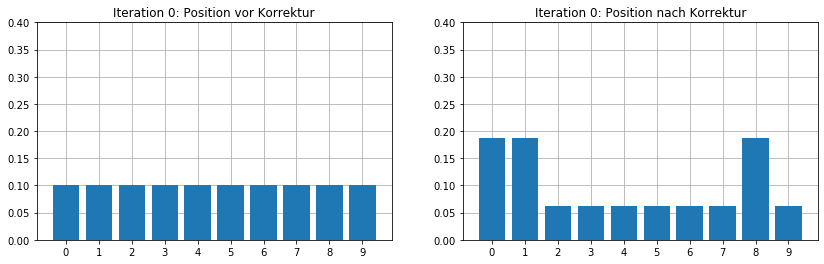

In [4]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0]) # Positions of open doors in hallway
initial_prior = np.array([.1] * 10) # no position information at all
prior_0 = initial_prior
likelihood = lh_hallway(hallway, z=1, z_prob=.75) # 1 stands for detection of open door detected
posterior_0 = update(likelihood, prior_0)
twoBarPlots(prior_0, 'Iteration 0: Position vor Korrektur', posterior_0, 'Iteration 0: Position nach Korrektur', y_lim=0.4)

#### Iteration 0:
Der linke Plot oben zeigt die Ausgangslage mit "Null" Wissen zur Fahrzeugposition. Der rechte Plot zeigt die Wahrscheinlichkeitsverteilung nach dem der Türsensor die Türe als offen detektiert hat. Dadurch sind an den Indizes 0, 1 und 8 die Aufenthaltswahrscheinlichkeiten angewachsen.  
> Der Übergang vom linken zum rechten Plot oben ist der "Korrekturschritt".    

#### Iteration 1:
Es folgt ein Vorhersageschritt: Mit der Information des Bewegungssensors (hier Bewegung um einen Schritt nach rechts) wird aus dem Posterior ein neuer Prior erzeugt.

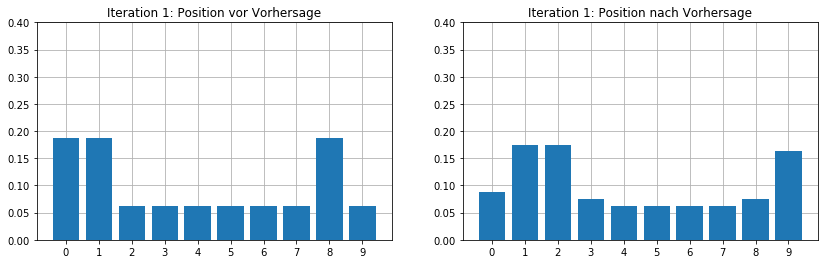

In [5]:
kernel = (.1, .8, .1)
prior_1 = predict(posterior_0, 1, kernel) # prediction with movement one step to the right
twoBarPlots(posterior_0, 'Iteration 1: Position vor Vorhersage', prior_1, 'Iteration 1: Position nach Vorhersage', y_lim=0.4)

Die Wahrscheinlichkeitsverteilung wird durch die Faltung mit dem Kernel um eine Position nach rechts verschoben und etwas verschmiert, wie im Vergleich der beiden Plots oben gut sichtbar ist.  
>Der Übergang vom linken zum rechten Plot oben ist der "Vorhersageschritt".  

Die erste Iteration wird anschließend mit einem Korrekturschritt abgeschlossen. Der Türsensor detektiert eine offene Türe. Damit ergibt sich grafisch als Histogramm dargestellt folgender Übergang durch die Korrektur:

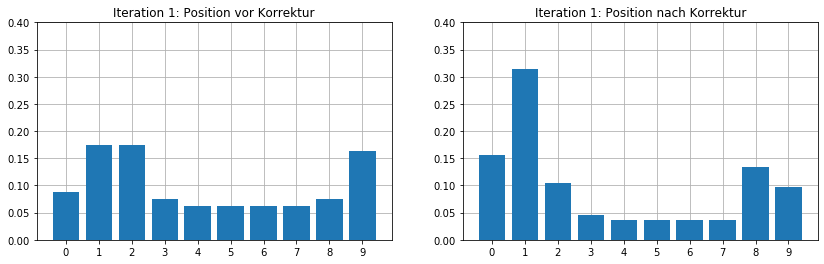

In [6]:
likelihood = lh_hallway(hallway, z=1, z_prob=.75) # 1 stands for detection of open door detected
posterior_1 = update(likelihood, prior_1)
twoBarPlots(prior_1, 'Iteration 1: Position vor Korrektur', posterior_1, 'Iteration 1: Position nach Korrektur', y_lim=0.4)

Infolge der Erkennung der offenen Tür wird der aktuelle Array Prior mit dem Array ``likelyhood`` multipliziert (darin steckt das Messergebnis ``z=1`` sowie dessen Signifikanz ``z_prob``). Dadurch steigen die Wahrscheinlichkeiten an den Positionen 0, 1 und 8. 
Die Wahrscheinlichkeitsverteilung der Fahrzeugposition wird deshalb konkreter, weil nun erneut eine offene Tür detektiert wurde,  nachdem das Fahrzeug eine Position nach Rechts gefahren war. Dies passt zu der im "Modell" angenommenen Verteilung der offenen Türen. Die erste Iteration ist damit abgeschlossen, der Filter gibt die Wahrscheinlichkeitsverteilung als Filterausgangssignal aus.  

**Die zweite und die folgenden Iterationen werden jeweils "in einem Rutsch" durchgeführt. Die Plots zeigen also jeweils den Posterior (Korrekturwert) nach Iteration 2, Iteration 3, usw.**

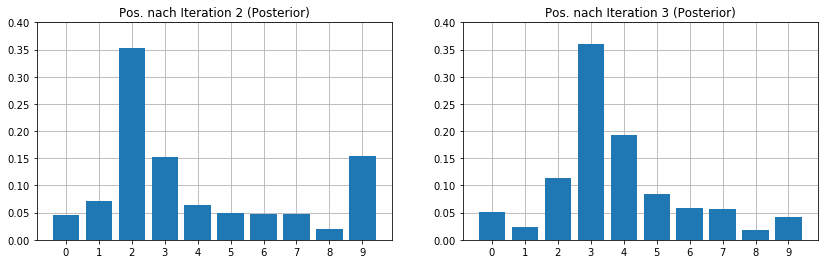

In [7]:
prior_2 = predict(posterior_1, 1, kernel) # prediction with movement one step to the right
likelihood = lh_hallway(hallway, z=0, z_prob=.75) # 0 stands for closed door detected
posterior_2 = update(likelihood, prior_2)

prior_3 = predict(posterior_2, 1, kernel) # prediction with movement one step to the right
likelihood = lh_hallway(hallway, z=0, z_prob=.75) # 0 stands for closed door detected
posterior_3 = update(likelihood, prior_3)

twoBarPlots(posterior_2, 'Pos. nach Iteration 2 (Posterior)', posterior_3, 'Pos. nach Iteration 3 (Posterior)', y_lim=0.4)

#### Iterationen 2 und 3:
*Achtung: Die Plots oben stehen nicht mehr nur für einen einzelnen Vorhersage- bzw. Korrekturschritt. Sie stellen nun jeweils die Positionsannahme (Posterior) nach einer kompletten Iteration aus Vorhersage und Korrektur dar.*  

Der Sensor detektiert eine Bewegung nach rechts um einen Schritt. Obwohl die Vorhersage mit den verrauschten Bewegungsmessdaten immer etwas die Daten verschmiert, tritt nach Iteration 2 die Position 2 trotzdem deutlicher hervor als nach Iteration 2 die Position 1. Dies ist auch für die Iteration 3 noch leicht der Fall. Der Effekt wird aber schwächer, da es wesentlich mehr geschlossene Türen (7) als offene Türen (3) gibt. Mit einem Messwert "Türe geschlossen" lässt sich das Fahrzeug wesentlich schlechter lokalisieren als mit einem Messwert "Türe offen".

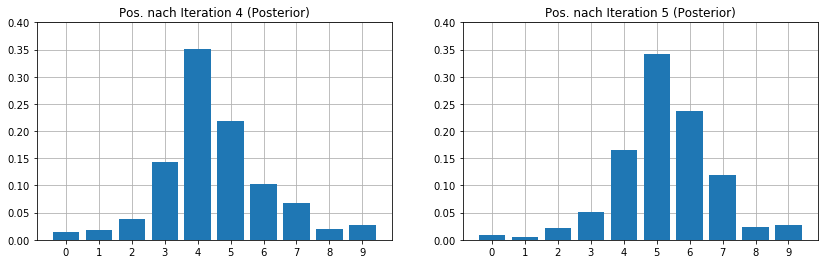

In [8]:
prior_4 = predict(posterior_3, 1, kernel) # prediction with movement one step to the right
likelihood = lh_hallway(hallway, z=0, z_prob=.75) # closed door detected
posterior_4 = update(likelihood, prior_4)

prior_5 = predict(posterior_4, 1, kernel) # prediction with movement one step to the right
likelihood = lh_hallway(hallway, z=0, z_prob=.75) # closed door detected
posterior_5 = update(likelihood, prior_5)

twoBarPlots(posterior_4, 'Pos. nach Iteration 4 (Posterior)', posterior_5, 'Pos. nach Iteration 5 (Posterior)', y_lim=0.4)

#### Iterationen 4 und 5:
Da wiederholt nun geschlossene Türen gemessen werden, nimmt die Lokalisierung des Fahrzeugs nach Iteration 4 und 5 leicht ab. Denn eine geschlossene Tür kann wie schon erwähnt 7 der 10 Positionen zugeordnet werden.  
Die Faltung mit dem Bewegungsarray (Vorhersageschritt) verschmiert immer die Verteilung etwas. Die Multiplikation mit der Likelyhood (Korrekturschritt) kann dies aber jetzt nicht komplett gegenkompensieren.  
Betrachtet man den Verlauf der Histogramme über alle sechs Iterationen, so hat sich die Lokalisierung des Fahrzeugs doch erheblich konkretisiert. Stets ist die wahre Position des Fahrzeugs auch dort, wo die Wahrscheinlichkeitsverteilung ihr Maximum besitzt.

## Der Bayes-Filter-Algorithmus
### Rückblick auf den g-h-Filter des ersten Jupyter-Notebooks
Für die Vorhersagen wurden in den obigen Beispielen zunächst Bewegungsinformationen eines verrauschten Bewegungssensors verwendet. Im Jupyter-Notebook zum g-h-Filter kam jedoch die Bewegungsinformation (Abstandsänderung zur Wand) wie im letzten Beispiel aus dem physikalischen Modell.  
Weiter unten im Abschnitt "Simulation und Tracking eines Roboterfahrzeugs im kreisförmigen Flur mit Vorhersage über Steuerbefehle statt Bewegungssensorwerte" wird eine dritte Möglichkeit verwendet, um den Vorhersageschritt mit den nötigen Informationen zu versorgen: Wenn das Roboterfahrzeug gesteuert wird, dann können die Steuerbefehle für die Bewegung als Input verwendet werden.  

Ein ganz wesentlicher Unterschied zwischen dem g-h-Filter und dem Bayes-Filter sind die *Statistikgrundlagen*:  
In den Jupyter-Notebooks zum g-h-Filter sind im Filteralgorithmus keine statistischen Berechnungen zu finden. Die Zustandsgröße "Abstand zur Wand" konnte innerhalb der Sensorauflösung beliebige Werte annehmen. Implizit wurde angenommen, dass der Schätzwert des Wandabstands um den (einen) wahren Wert streut. Es wurde also stillschweigend eine sogenannte **"unimodale" Wahrscheinlichkeitsdichte** angenommen: Es war anders als beim Bayes-Filter nie die Rede davon, das Fahrzeug könne sich mit ähnlicher Wahrscheinlichkeit  beispielsweise 200 mm und 400 mm von der Wand entfernt befinden.  

### Der Bayes-Filter als Vorhersage-Korrektur-Algorithmus
Dem Bayes-Filter liegt eine ganz anderer Umgang mit der Wahrscheinlichkeitsrechnung als dem g-h-Filter zugrunde:  

>Beim Bayes-Filter geht es um **multimodale Wahrscheinlichkeitsverteilungen**: Als Ergebnis einer Schätzung kann das Fahrzeug sich mit gleicher Wahrscheinlichkeit an zwei verschiedenen Positionen befinden, wie es einige der Histogramme oben auch verdeutlichen. Hier geht es nicht um eine Zustandsgröße, die um einen Erwartungswert streut. Es geht um ein Array, dessen Elemente für die verschiedenen Zustände des Systems stehen. Der Wert des jeweiligen Elements gibt dabei die geschätzte Wahrscheinlichkeit für diesen Zustand aus.  

Konkret ist dies oben das Array ``posterior``, dessen zehn Elemente für die zehn möglichen Positionen im Flur stehen. Wäre der Flur doppelt so lange, dann hätte das Array zwanzig Elemente.  
Bildlich ausgedrückt geht es beim Bayes-Filter um *Histogramme*, beim g-h-Filter geht es um einen einzelnen Wert.

In folgender Grafik ist nochmals der Algorithmus des g-h-Filters verdeutlicht. Das selbe Bild wurde schon im entsprechenden Jupyter-Notebook dazu dargestellt. Er besteht aus einer Initialisierung mit Startwerten und anschließenden Iterationen. Jede Iteration besteht aus einem Vorhersageschritt (engl. Prediction) und aus einem Korrekturschritt (engl. Update). Die Vorhersage wird mit Hilfe des physikalischen Modells gemacht, die Korrektur mit Hilfe neuer Messwerte.   
Nach dem Korrekturschritt gibt der Filter jeweils neue Schätzwerte aus, die dann beispielsweise in einen Regelalgorithmus einfließen.

![title](gh_AlgoGrafik.png)

> Der bis hierhin entwickelte Bayes-Filter folgt genau dem selben Schema. Um das Verständnis zu vereinfachen wurde lediglich ein Bewegungssensor eingeführt, welcher anstelle des physikalischen Modells den Input für die Vorhersage liefert. Im Abschnitt "Vorhersage ohne Bewegungssensor unter der Annahme einer gleichförmigen Bewegung" wurde folglich dann auf den Sensor verzichtet und dessen Unsicherheit als Unsicherheit des physikalischen Modells interpretiert.  

Der Bayes-Filter ist also eine Form des g-h-Filters. Es macht aber hier keinen Sinn, heraus zu bekommen, wie er die beiden Parameter $g$ und $h$ bestimmt. Die beiden Parameter werden implizit über die verschiedenen Wahrscheinlichkeitsverteilungen berechnet. 

An dieser Stelle ist es sinnvoller, sich mit den Grundgleichungen des Bayes-Filters zu beschäftigen:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf {\hat x} \ast f_{\mathbf x}\, \, &\text{Vorhersageschritt} \\ 
\mathbf {\hat x} &= \|\mathcal L \circ \bar{\mathbf x}\|\, \, &\text{Korrekturschritt} \end{aligned}$$

$\mathcal L$ ist die übliche Bezeichnung für die Likelyhood. Die Notation $\|\|$ steht für die Normierung, die nötig ist, damit die Summe der Wahrscheinlichkeitsverteilung $x$ den Wert 1 ergibt. Das Zeichen $\circ$ steht für die elementweise Multiplikation der beiden Vektoren.  
$f_x$ nennt man *Zustandspropagationsfunktion*. Sie gibt an, wie sich $x_k$ während eines Zeitschritts ändert.

Die beiden Grundgleichungen lassen sich so in Pseudocode umsetzen:

**Initialisierung**

1. Ein physikalisches Modell erstellen und daraus eine mathematische Berechnungsformel für die Vorhersage ableiten.
2. Eine initiale Annahme über den Zustand treffen. (Hier für jede Türposition die selbe Wahrscheinlichkeit von 10 %, initialer Vorhersagewert.) Bei der nullten Iteration also statt einer Vorhersage eine Initialisierung


**Vorhersage**

1. Vorhersage eines Schätzwerts für den Zustand nach dem nächsten Zeitschritt. (Hier basierend auf dem phys. Modell oder auf dem Bewegungsmesswert "N Positionen nach Links", "Stillstand" oder "N Positionen nach Rechts".)
2. Die Positionsannahme anpassen unter Berücksichtigung der Unsicherheit der Vorhersage (hier Unsicherheit des physikalischen Modells oder des Bewegungsmesswerts) und Vorhersagewert ausgeben.

    
**Korrektur**

1. Messwert anfordern inkl. dessen statistischer Messunsicherheit. (Hier "Türe offen" oder "Türe geschlossen".)
2. Berechnung der Likelihood, d.h. wie gut die aktuelle Messung sich mit den verschiedenen möglichen Zuständen deckt. (Hier über das vorliegenden Muster der offenen bzw. geschlossenen Türen, je nach Türmesswert.)
3. Die Positionsannahme anpassen unter Berücksichtigung der berechneten Likelihood (generell über die Multiplikation der beiden Arrays zur Positionsannahme und Likelihood) und Korrekturwert als neuen Schätzwert ausgeben.
    


Wenn es später um den Kalman-Filter geht, dann wird genau dieser obige Algorithmus wieder verwendet. 

>Algorithmen dieser Form bezeichnet man als *Vorhersage-Korrektur*-Algorithmen: Zuerst wird eine Vorhersage erstellt welche anschließend korrigiert wird.

### Nachteile und Einschränkungen des Bayes-Filters

Der Bayes-Filter, wie er hier vorgestellt wurde, wird in dieser Form eher selten angewendet. Dies liegt an drei grundsätzlichen Nachteilen:

Will man mehrere Zustandsgrößen filtern, dann werden die Arrays mit den Schätzwerten mehrdimensional und schnell unübersichtlich. In den Beispielen dieses Jupyter-Notebooks waren nur die Position in einer Richtung (Kreisrichtung) von Interesse. Würde man als weitere Zustandsgrößen noch den Wandabstand, die Geschwindigkeit entlang der Kreisbahn und senkrecht dazu filtern, dann würde ``posterior`` zu einem vierdimensionalen Array anwachsen. Der Rechenaufwand würde dadurch stark ansteigen.  

Der zweite Nachteil ist die grobe Diskretisierung der Zustandsgröße (hier Position) in Array-Elemente. Will man die Position im Flur feiner auflösen, z.B. statt 10 nun 10.000 mögliche Positionen, dann wachsen dadurch die Arrays entsprechend an. Auch hierdurch steigt der Rechenaufwand stark an.  

Ein dritter Nachteil ist die schon besprochene *multimodale* Wahrscheinlichkeitsverteilung. Es gibt Applikationen, die erfordern einen unimodalen Filteroutput: Wenn z.B. die Position via GPS ermittelt wird, dann erwarten die Benutzer eine eindeutige konkrete Positionsangabe und nicht drei verschiedene mögliche Positionen mit ähnlicher Wahrscheinlichkeit.  

Trotzdem ist dieses Notebook sehr wichtig für das spätere Verständnis des Kalman-Filters.

## Simulation und Tracking eines Roboterfahrzeugs im kreisförmigen Flur mit Vorhersage über Steuerbefehle statt Bewegungssensorwerte und mit einem Abstandssensor statt Türsensor

Das Gedankenexperiment mit dem Roboterfahrzeug im Flur ist zugegeben etwas an den Haaren herbei gezogen.  
Besonders der Bewegungssensor, dessen Signal für die Vorhersage verwendet wurde, ist eigentlich an einem Roboterfahrzeug nicht nötig. Denn das Fahrzeug muss in irgendeiner Weise gesteuert werden, und bewegt sich daher mehr oder minder vorhersehbar. Daher kennt man zumindest die Steuerbefehle und kann daraus Rückschlüsse auf die Sollbewegung des Fahrzeugs ziehen.   

In diesem Sinne wird das Gedankenexperiment weiter gesponnen:  
Das Fahrzeug erhält nun von Außen zu jeder Samplingzeit (hier jede Sekunde) einen Steuerbefehl für seine Bewegung. Der Befehl kann z.B. "*4 Positionen nach Rechts*", "*Stopp*" oder "*2 Positionen nach Links*" lauten. **Dieser Steuerbefehl dient als Input für die Vorhersage.**      
Welche Bewegung das Fahrzeug tatsächlich ausführt, steht auf einem anderen Blatt: Die Motoren und die Räder sind nicht perfekt, der Untergrund ist nicht absolut eben und überall gleich griffig.  
Hierdurch kommt wieder eine statistische Unsicherheit in die tatsächlich ausgeführte Bewegung hinein. Eine Soll-Bewegung um 5 Positionen nach Rechts endet mit einer bestimmten Wahrscheinlichkeit in einer tatsächlichen Bewegung um 4, 6 oder gar 7 Positionen in diese Richtung.  
Statistisch verhält sich diese Soll-Ist-Abweichung genau so wie die Messabweichung des Bewegungssensors in den voran gegangenen Abschnitten. Der Vorhersagefunktion ``predict()`` wird somit nicht mehr der Bewegungsmesswert sondern der Bewegungsbefehl übergeben. Ansonsten bleibt Alles beim Alten.  

Um das Gedankenexperiment weiter zu vereinfachen, soll das Roboterfahrzeug nach wie vor auf einem kreisförmigen Flur unterwegs sein. Es wird auch wieder entlang des Flurs geführt, so dass es parallel zur Wand fährt.  
Bisher gab es in diesem Flur zehn verschiedene Türpositionen, an denen das Fahrzeug sich befinden kann. Diese Zahl ist nun über den Parameter ``track_len`` frei wählbar.
**Auf Position 0 befindet sich ein Abstandssensor, der mit einer vorgegebenen Messunsicherheit den Abstand des Fahrzeugs entlang des Flurs zyklisch erfasst. Der Abstandsensor misst also direkt die Position des Fahrzeugs auf dessen Kreisbahn im Flur.** Seine Auflösung ist die der möglichen Positionen, d.h. der Abstandssensor gibt als Messwert eine der möglichen Türpositionen aus, keine Werte dazwischen. Der Türsensor, welcher mit seinem Messwert "Türe offen" oder "Türe geschlossen" zusammen mit dem Muster der geöffneten Türen eine Postitionsannahme lieferte, hat nun ausgedient. Die Position wird nun direkt gemessen und es handelt sich hierbei auch nicht mehr um eine multimodale Wahrscheinlichkeitsverteilung. Die Positionsmesswerte streuen um die wahre Positionas des Fahrzeugs.  

**Nach wie vor wird hier ein Bayes-Filter verwendet. Die Positionsannahme könnte auch hier von der verwendeten Mathematik her multimodal sein. Aufgrund der unimodalen Streuung von Positionsmesswert und Bewegung wird sich jedoch eine unimodale Wahrscheinlichkeitsverteilung der Position ergeben. Dies ist schon ein erster Schritt in Richtung Kalman-Filter. Jedoch werden die Wahrscheinlichkeiten hier immer noch wertdiskret als Histogramme angenommen. Später beim Kalman-Filter nimmt man Gaßverteilungen und wertkontinuierliche Zustände (Positionen) an.**

### Die Klasse RoboCar für die Simulation der Bewegung und der Abstandsmesswerte
Für das Roboterfahrzeug wird die Klasse ``RoboCar`` erstellt. Diese enthält die Methode ``move()`` für die tatsächliche Bewegung nach einen Bewegungsbefehl und die Methode ``sense()`` für die Durchführung einer Abstandsmessung.  

Beide Methoden sind mit einer statistischen Unsicherheit behaftet:  
1. Zu ``move()`` gehört eine Faltungskern (engl. Kernel) der die tatsächliche Bewegung gegenüber der Soll-Bewegung ``distance`` "verschmiert". Die Elemente des Kernels geben an, mit welcher Wahrscheinlichkeit eine Abweichung eintritt. Beispielsweise bedeutet ein Kernel (0.1,0.8,0.1), dass zu 10 % die tatsächliche Bewegung um 1 kleiner, zu 10 % um 1 größer und zu 80 % ohne Abweichung ausfällt.
2. Zu ``sense()`` gehört das Attribut ``sensor_accuracy``. Mit einer Wahrscheinlichkeit von $(1-sensor\_accuracy)$ erhält der Messwert eine Abweichung von 1 (einer Türposition). Diese Abweichung ist symmetrisch, der Messwert weicht also genau so oft nach oben wie nach unten ab. Beträgt ``sensor_accuracy`` beispielsweise 0.90 und der wahre Abstandswert 7, dann wird der Sensor mit einer Wahrscheinlichkeit von jeweils 5 % als Messwert 6 oder 8 ausgeben.

In [9]:
class RoboCar(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel # must have odd number of elements, center element means no error
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ move in the specified direction
        with some small chance of error"""

        self.pos += distance
        # insert random movement error according to kernel
        r = random.random() # generates random number between 0...1
        s = 0
        offset = -(len(self.kernel) - 1) / 2  # starting with maximum negative error value
        for k in self.kernel:
            s += k # adding up kernel elements (=probabilities), last possible run: s = 1 
            if r <= s:
                break # each run more likely depending on kernel element probabilities
            offset += 1 # next 1 unit bigger until max positive error value
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        pos = self.pos
        # insert random sensor error of -1 or +1.  
        if random.random() > self.sensor_accuracy: # more likely for smaller accuracy
            if random.random() > 0.5: # 50/50 chance for negative/positive error
                pos += 1
            else:
                pos -= 1
        return pos

Die Methoden der Klasse ``RoboCar`` simulieren sowohl die Bewegung des Fahrzeugs als auch die Messung des Abstands. Ein Bewegungsschritt wird durch die Methode ``move()`` ausgeführt. Damit wird das Fahrzeug von außen gesteuert.  

### Die Funktion robo_filter() für das Tracking mittels Bayes-Filter
Im folgenden Quellcode der Funktion ``robo_filter()`` wird ein Bayes-Filter implementiert, der das Roboterfahrzeug trackt, will heißen, dessen aktuelle Position (Zustandswert) aus dem Maximum der Positionsannahme bestimmt.  
Das Fahrzeug startet immer an der Position 0. Im nachfolgenden Beispiel wird eine Flurlänge von nur 10 Positionen gewählt, damit die Plots übersichtlich bleiben. 

In [10]:
def robo_filter(iterations, kernel, sensor_accuracy, move_distance, do_print=True):
    # identical kernel for prediction and movement error
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) # needed for likelihood calculation, contains possible states
    prior = np.array([.9] + [0.01]*9) # robot with 90 % confidence at start position 0
    posterior = prior[:] 
    prior = prior/np.sum(prior) # normalize prior
    
    robot = RoboCar(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        robot.move(distance=move_distance) # simulation movement step, true position is robot.pos
        prior = predict(posterior, move_distance, kernel) # predition based on movement error kernel       
        z = robot.sense() # distance measurement with sensor_accuracy
        likelihood = lh_hallway(track, z, sensor_accuracy) #compute position likelihood including sensor error
        posterior = update(likelihood, prior)
        i_post = np.argmax(posterior) # find index (=position) with highest probability
        i_prio = np.argmax(prior)

        if do_print:
            print('t={:2}: Wahr {}, Vorh. {}, Mess. {}, Schätz. {}, Konf. {:.4f} %'.format(
                    i, robot.pos, i_prio, z, i_post, posterior[i_post]*100)) 
         

    barPlot(posterior)
    if do_print:
        print()
        print('Letzte wahre Position ist ', robot.pos)
        print('Letzte geschätzte Position ist {} mit Konfidenz {:.4f} %'.format(i_post, posterior[i_post]*100))

Um die Berechnung der Likelihood im Code oben nachzuvollziehen, macht es Sinn, nochmals einen Blick auf die wesentlichen Codezeilen der aufgerufenen Funktion ``lh_hallway(track, z, sensor_accuracy)`` zu werfen:  

```Python
def lh_hallway(hallway, z, z_prob):
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hallway))
    # only state of likelihood equal to z will be scaled
    likelihood[hallway==z] *= scale # [hallway==z] selects index of position z
    return likelihood
```
Jedes Element des Arrays ``likelyhood`` entspricht einem möglichen Zustand. Daher wird dieser Array mit der selben Größe wie ``hallway`` angelegt, denn in letzteren Array stecken die Abstandswerte 0...9 für die hier 10 verschiedenen Fahrzeugpositionen. Der Messwert ``z`` ist eine Position, die einem Index von ``likelyhood`` bzw. ``hallway`` entspricht. Das Element von ``likelyhood`` an diesem Index wird um den Faktor ``scale`` vergrößert, der angibt, wieviel wahrscheinlicher der Sensor richtig als falsch gemessen hat. 

### Verknüpfung von Simulation und Tracking
Der Roboterfahrzeug wird mit konstanter Geschwindigkeit simuliert: Bei jeder Iteration legt es im Mittel ``move_distance`` Schritte zurück. Über den Kernel wird gesteuert, wie stark die tatsächliche Schrittanzahl streut. Die wahre Position unter Berücksichtigung der Streuung wird im Attribut ``.pos`` abgelegt.  
Die Vorhersage kennt die aktuelle tatsächliche Schrittanzahl nicht, sondern geht von der Sollschrittanzahl ``move_distance`` aus. Sie berücksichtigt aber die über den Kernel spezifizierte Streuung dieser Sollschrittweite. Das macht Sinn, denn diese Streuung der Schrittanzahl könnte vorher ja am Roboterfahrzeug bestimmt werden, und ist damit eine Systemeigenschaft. Das Roboterfahrzeug startet immer an der Position 0.

Der mit der Vorhersage erstellte Vorhersagewert (Prior) wird nun mit dem (simulierten) Messwert der Position korrigiert. Dieser Abstandsmesswert hat eine Unsicherheit von +/-1 Schrittweiten. Die Wahrscheinlichkeit, dass es eine Messabweichung gibt, ist (1 - sensor_accuracy), eine Abweichung von +1 ist genau so wahrscheinlich wie eine von -1. Das Ergebnis der Korrektur ist ein neuer Korrekturwert, d.h. eine neue normierte Likelyhood, oder anders ausgedrückt eine Wahrscheinlichkeitsverteilung der Position. *Deren Maximum wird als Schätzwert des Zustands ausgegeben.*  

Danach beginnt eine neue Iteration.

**Der ausgegebene Positions-Schätzwert ist also der Index der Wahrscheinlichkeitsverteilung, in dem sich das Maximum findet. Denn die diesem Index entsprechende Position ist die Position, wo sich das Fahrzeug am wahrscheinlichsten aufhält. Wie sicher sich der Filter, ist, dass das Fahrzeug wirklich dort ist, wird durch den Wert des Array-Elements ausgedruckt: Er ist die sogenannte "Konfidenz" oder anders ausgedrückt das "Vertrauensniveau".**   

Über den Befehl ``random.seed(10)`` im Code wird bewirkt, dass die Folge der Zufallszahlen bei jeder Ausführung des Codes die selbe ist. Nur so ist es in diesem Notebook für den Autor machbar, sich im Text auf einen bestimmten statistischen Ausreißer zu beziehen.  
Die mittlere Geschwindigkeit beträgt bei allen Simulationen 4 pro Sekunde und ist konstant.

#### Simulation Roboterfahrzeug mit idealem Abstandsensor und ohne Bewegungsabweichung
Die folgende Simulation dient dazu, die Klasse ``RoboCar`` und die Funktion ``robo_filter()`` zu testen:  
Die Sollgeschwindigkeit ist 4 pro Sekunde, der Abweichung der Ist-Bewegung ist 0 und der Abstandssensor liefert zu 99,9 % fehlerfreie Messwerte - Ideale Bedingungen also.  
Der Flur ist kreisförmig und 10 Positionen lang: Daher kommt nach Position 8 und einer Bewegung von 4 Schritten wieder die Position 2. Die Schätzwerte entsprechen alle den wahren Positionen, und es verwundert nicht, dass die Konfidenz schnell 100 % groß wird.  

t= 0: Wahr 4, Vorh. 4, Mess. 4, Schätz. 4, Konf. 99.9900 %
t= 1: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 100.0000 %
t= 2: Wahr 2, Vorh. 2, Mess. 2, Schätz. 2, Konf. 100.0000 %
t= 3: Wahr 6, Vorh. 6, Mess. 6, Schätz. 6, Konf. 100.0000 %
t= 4: Wahr 0, Vorh. 0, Mess. 0, Schätz. 0, Konf. 100.0000 %
t= 5: Wahr 4, Vorh. 4, Mess. 4, Schätz. 4, Konf. 100.0000 %
t= 6: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 100.0000 %
t= 7: Wahr 2, Vorh. 2, Mess. 2, Schätz. 2, Konf. 100.0000 %
t= 8: Wahr 6, Vorh. 6, Mess. 6, Schätz. 6, Konf. 100.0000 %
t= 9: Wahr 0, Vorh. 0, Mess. 0, Schätz. 0, Konf. 100.0000 %
t=10: Wahr 4, Vorh. 4, Mess. 4, Schätz. 4, Konf. 100.0000 %
t=11: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 100.0000 %

Letzte wahre Position ist  8
Letzte geschätzte Position ist 8 mit Konfidenz 100.0000 %


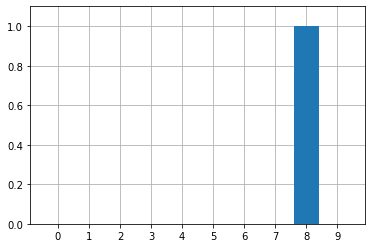

In [11]:
import random

random.seed(10)
np.set_printoptions(precision=2, suppress=True, linewidth=60)
robo_filter(12, kernel=[0,1.,0], sensor_accuracy=.999,
             move_distance=4, do_print=True)

Der Code funktioniert also einwandfrei.

#### Simulation Roboterfahrzeug mit fast idealem Abstandsensor und signifikanten Bewegungsabweichungen
Nun wird eine Simulation mit fast noch idealen Sensor aber signifikanten Bewegungsabweichungen durchgeführt.

t= 0: Wahr 4, Vorh. 4, Mess. 4, Schätz. 4, Konf. 98.8621 %
t= 1: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 99.1057 %
t= 2: Wahr 2, Vorh. 2, Mess. 2, Schätz. 2, Konf. 99.1126 %
t= 3: Wahr 6, Vorh. 6, Mess. 6, Schätz. 6, Konf. 99.1128 %
t= 4: Wahr 0, Vorh. 0, Mess. 0, Schätz. 0, Konf. 99.1128 %
t= 5: Wahr 4, Vorh. 4, Mess. 4, Schätz. 4, Konf. 99.1128 %
t= 6: Wahr 9, Vorh. 8, Mess. 9, Schätz. 9, Konf. 89.7613 %
t= 7: Wahr 4, Vorh. 3, Mess. 4, Schätz. 4, Konf. 88.4094 %
t= 8: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 98.8244 %
t= 9: Wahr 2, Vorh. 2, Mess. 2, Schätz. 2, Konf. 99.1055 %
t=10: Wahr 6, Vorh. 6, Mess. 6, Schätz. 6, Konf. 99.1126 %
t=11: Wahr 9, Vorh. 0, Mess. 9, Schätz. 9, Konf. 89.7614 %

Letzte wahre Position ist  9
Letzte geschätzte Position ist 9 mit Konfidenz 89.7614 %


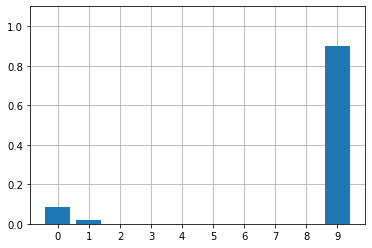

In [12]:
random.seed(10)
robo_filter(12, kernel=[.15, .7, .15], sensor_accuracy=.98,
         move_distance=4, do_print=True)

In dem Fall oben ist die Messabweichung des Sensors sehr gering, jedoch liegt die Vorhersage manchmal daneben, wenn die tatsächliche Schrittweite von ``move_distance`` abweicht, wie z.B. zur Zeit 6. Dies bewirkt einen vorrübergehenden moderaten Einbruch der Konfidenz.

#### Simulation Roboterfahrzeug mit realitätsnahem Abstandsensor und leichten Bewegungsabweichungen
Es folgt eine Simulation mit geringen Bewegungsabweichungen aber eine Messabweichung, die der einfacher preiswerter Sensoren entspricht.

t= 0: Wahr 4, Vorh. 4, Mess. 4, Schätz. 4, Konf. 95.0237 %
t= 1: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 96.9404 %
t= 2: Wahr 2, Vorh. 2, Mess. 3, Schätz. 2, Konf. 92.8359 %
t= 3: Wahr 6, Vorh. 6, Mess. 6, Schätz. 6, Konf. 95.9512 %
t= 4: Wahr 0, Vorh. 0, Mess. 0, Schätz. 0, Konf. 97.3676 %
t= 5: Wahr 4, Vorh. 4, Mess. 3, Schätz. 4, Konf. 93.0906 %
t= 6: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 96.0738 %
t= 7: Wahr 2, Vorh. 2, Mess. 2, Schätz. 2, Konf. 97.4244 %
t= 8: Wahr 6, Vorh. 6, Mess. 6, Schätz. 6, Konf. 98.0209 %
t= 9: Wahr 0, Vorh. 0, Mess. 0, Schätz. 0, Konf. 98.2814 %
t=10: Wahr 4, Vorh. 4, Mess. 5, Schätz. 4, Konf. 94.1064 %
t=11: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 96.5400 %

Letzte wahre Position ist  8
Letzte geschätzte Position ist 8 mit Konfidenz 96.5400 %


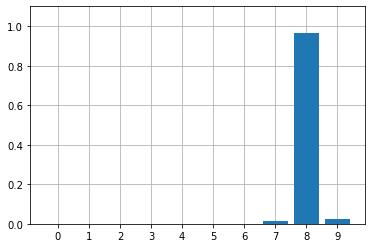

In [13]:
random.seed(10)
robo_filter(12, kernel=[.01, .98, .01], sensor_accuracy=.70,
         move_distance=4, do_print=True)

Die Vorhersage liegt nie daneben. Jedoch sinkt die Konfidenz der geschätzten Position nach einem Ausreißer des Abstandssensors deutlich ab, wie z.B. zur Zeit 5. Dies heilt nach einigen Schritten ohne Ausreißer aber wieder aus.

#### Simulation Roboterfahrzeug mit stark streuenden Abstandsensor und deutlichen Bewegungsabweichungen
Diese Simulation besitzt sowohl für die Bewegungsabweichungen als auch für die Messunsicherheit recht große Werte, die realitätsnah für preiswerte Mechatronikkomponenten sind.

t= 0: Wahr 4, Vorh. 4, Mess. 4, Schätz. 4, Konf. 85.5152 %
t= 1: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 80.6067 %
t= 2: Wahr 2, Vorh. 2, Mess. 3, Schätz. 2, Konf. 76.1351 %
t= 3: Wahr 6, Vorh. 6, Mess. 5, Schätz. 6, Konf. 72.0570 %
t= 4: Wahr 0, Vorh. 0, Mess. 1, Schätz. 0, Konf. 68.3334 %
t= 5: Wahr 4, Vorh. 4, Mess. 5, Schätz. 4, Konf. 64.9296 %
t= 6: Wahr 8, Vorh. 8, Mess. 8, Schätz. 8, Konf. 61.8142 %
t= 7: Wahr 2, Vorh. 2, Mess. 2, Schätz. 2, Konf. 58.9594 %
t= 8: Wahr 6, Vorh. 6, Mess. 5, Schätz. 6, Konf. 56.3399 %
t= 9: Wahr 0, Vorh. 0, Mess. 1, Schätz. 0, Konf. 53.9333 %
t=10: Wahr 4, Vorh. 4, Mess. 4, Schätz. 4, Konf. 51.7194 %
t=11: Wahr 7, Vorh. 8, Mess. 7, Schätz. 8, Konf. 49.6799 %

Letzte wahre Position ist  7
Letzte geschätzte Position ist 8 mit Konfidenz 49.6799 %


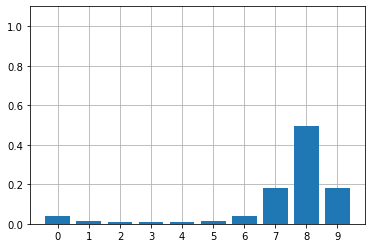

In [14]:
random.seed(10)
robo_filter(12, kernel=[.03, .94, .03], sensor_accuracy=.50,
         move_distance=4, do_print=True)

In dem Worst Case Beispiel oben ist schön zu sehen, dass der Filter sich immer wieder fängt, falls mal ein Ausreißer im Messwert oder in der Schrittanzahl zugeschlagen hat.  
**Spätestens jetzt muss gefragt werden, ob die Schätzwerte des Bayes-Filters wirklich näher an den wahren Werten liegen als die Messwerte.** Dazu sind in folgendem Plot diese Werte für eine im Vergleich zum Sensorrauschen (sensor_accuracy=0.5) vergleichsweise kleinen Bewegungsabweichung (kernel=(0.03, 0.94, 0.03)) miteinander verglichen: Der Schätzwert ist hier weitaus näher am wahren Wert als der Messwert. D.h. ein gutes physikalisches Modell bzw. gut vorhersagbares System (entspricht hier kleinen Bewegungsabweichungen) kann die sehr schlechten Sensormesswerte hinreichend gut korrigieren.  
Dabei bedeutet "gut vorhersagbares System" ein System, welches deterministisch physikalischen Gesetzen gehorcht und nicht etwa dem Zufall unterliegt. "Gutes physikalisches Modell", bedeutet, dass man diese Gesetze gut kennt und daraus ein realitätsnahes Modell bilden kann. Etwa die Lottozahlen wird man leider nie mit einem Bayes-Filter vorhersagen können.

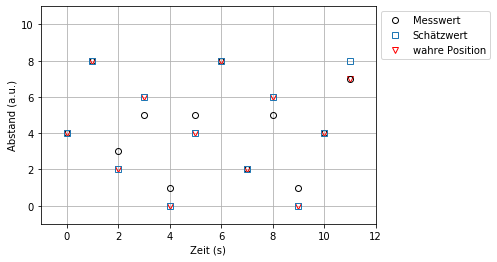

In [15]:
real_positions=[4,8,2,6,0,4,8,2,6,0,4,7]
measurements=[4,8,3,5,1,5,8,2,5,1,4,7]
estimates=[4,8,2,6,0,4,8,2,6,0,4,8]
plt.figure()
xs = range(12)
real, = plt.plot(xs, real_positions, c='r', marker='v', linestyle='None', mfc='None')
meas, = plt.plot(xs, measurements, c='k', marker = 'o', linestyle='None', mfc='None')
est, = plt.plot(xs, estimates, marker='s',linestyle='None', mfc='None')  
plt.legend([meas, est, real], ['Messwert', 'Schätzwert', 'wahre Position'],
               loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (a.u.)')
plt.xlim([-1, 12])
plt.ylim([-1, 11])
plt.grid()

#### Große Anzahl Iterationen mit realitätsnahen Abstandssensor und realitätsnahen Bewegungsabweichungen
Im abschließenden Code werden sehr viele Iterationen ausgeführt, wovon neun aufeinanderfolgende als Histogramme dargestellt werden.  
*Achtung*: Die Ausführung dieses Codes dauert ein wenig länger als gewöhnt.

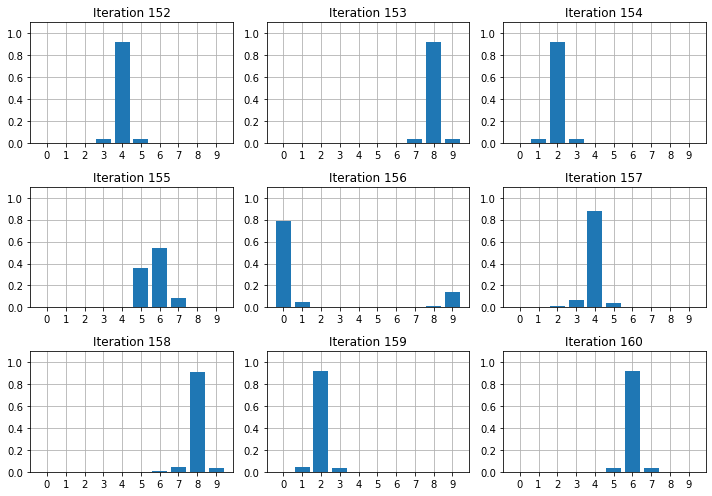

In [16]:
plt.figure(figsize=(10, 7)) # figure size
for i in range (9):
    random.seed(3)    
    plt.subplot(3,3,1+i) # 3x3 plots in figure, 1+i is number of active plot
    robo_filter(152+i, kernel=[.1, .8, .1], sensor_accuracy=.8, move_distance=4, do_print=False)
    plt.title ('Iteration {}'.format(152+i))
    plt.tight_layout()

Es ist gut sichtbar, wie die Position sich von Iteration zu Iteration um 4 Schritte ändert. Das Roboterfahrzeug fährt also immer im Kreis.  
Bei Iteration 155 sinkt auf einmal die Konfidenz auf unter 60 % ab. Aber bei Iteration 159 ist die Wahrscheinlichkeitsdichte der Position wieder angewachsen auf das vorherige Niveau von ca. 85 %.  
Es gibt also immer wieder mal Einbrüche der Konfidenz - entweder durch einen falschen Messwert oder durch eine falsche Vorhersage.

## Am Ende nun die Theorie: Keine Angst vor dem Bayes Theorem
Am besten löst man ein Problem zunächst hemdsärmelig mit viel Intuition und gesundem Menschenverstand. Erst danach sollte man sich Gedanken über die Theorie dazu machen. Diesem Leitbild folgt dieses Jupyter-Notebook. Bisher sind noch keine Theoreme oder komplizierten Matrizengleichungen aufgetaucht. Zum Glück.  

Denn viele Lehrbücher zum Kalman-Filter gehen genau den umgekehrten Weg: Sie knallen dem Leser erst die Theorie vor den Latz und präsentieren anschließend - wenn überhaupt - einige wenige Anwendungsbeispiele dazu. Ein solches Vorgehen wird an Hochschule zumal auch als "Forschung" beschrieben. Aber auch an Gymnasien ist diese Pseudowissenschaftlichkeit oft zu finden, wenn die Lehrer sich für Fachwissenschaftler und nicht für Pädagogen halten. Genug gelästert.   

Die statistischen Betrachtungen im bisherigen Verlauf dieses Notebooks mündeten in die beiden zentralen Filterfunktionen ``predict()`` und ``update()``.

Der Funktion `update()` liegt folgende zentrale Berechnung zugrunde:

$$\mathtt{Posterior} = \frac{\mathtt{Likelihood} \circ \mathtt{Prior}}{\mathtt{Normierung}}$$ 

>Der *prior* ist eine Wahrscheinlichkeitsverteilung, die auf einer Vorhersage basiert, dem sogenannte *Vorhersagewert*. Die Messung liefert eine Annahme (engl. *Likelihood*) über den Zustand, mit der der Prior korrigiert und daraus der Korrekturwert *Posterior* berechnet wird. Der Posterior ist der Schätzwert zur Wahrscheinlichkeitsverteilung, den der Filter schließlich ausgibt.

#### Das Bayes-Theorem
Das Bayes-Theorem lautet:

$$P(A \mid B) = \frac{P(B \mid A)\, P(A)}{P(B)}$$

*Wieder liegt der Hase in der Notation und in den Begrifflichkeiten begraben:*   
  
* Definition: $P(A)$ steht für die Eintrittswahrscheinlichkeit eines Ereignisses mit der Bezeichnung $A$.  
Wenn $A$ z.B. das Ergebnis "Zahl" bei einem Münzenwurf fist, dann wäre $P(A) = 0.5$, also 50 %.

* Definition: $P(A \mid B)$ nennt man "bedingte Wahrscheinlichkeit". Damit ist die Wahrscheinlichkeit gemeint für das Eintreten von Ereignis $A$ *wenn* gleichzeitig auch Ereignis $B$ eintritt.

Zum Beispiel ist das Ereignis "Regen" heute wahrscheinlicher, wenn es gestern auch schon geregnet hat. Die bedingte Wahrscheinlichkeit für heutigen Regen bei gleichzeitig gestrigen Regen würde also mit $P(\mathtt{Heute\_Regen} \mid \mathtt{Gestern\_Regen})$ ausgedrückt werden.

#### Der Update-Algorithmus als Spezialform des Bayes-Theorems
Nun wird gezeigt, dass die Wahrscheinlichkeitsverteilung des Roboterfahrzeugs dem Ereignis $A$ und eine Messung dem Ereignis $B$ des Bayes-Theorems entspricht:  

Dafür muss die Gleichung etwas umgeschrieben werden. $x_i$ steht für die Position mit Index *i* im Array der Wahrscheinlichkeitsdichte und $z$ für den Positionsmesswert. **Aufgabe der Funkton ``update()`` ist es $P(x_i \mid z)$ zu berechnen: Die Wahrscheinlichkeit der Position $x_i$ unter Berücksichtigung des Messwerts $z$.** 

Also gilt nach dem Bayes-Theorem:

$$P(x_i \mid z) = \frac{P(z \mid x_i) P(x_i)}{P(z)}$$

$P(x_i)$ ist der Prior, also die Wahrscheinlichkeit für die Position i nach der Vorhersage. Im Beispiel des Roboterfahrzeugs bedeutet beispielsweise $i = 4$ die Position 4, also vor der Türe 4. $P(x_4)$ ist dann die Wahrscheinlichkeit, dass sich das Fahrzeug an Position 4 befindet.  

$P(z \mid x_i)$ ist die bedingte Wahrscheinlichkeit für einen Messwert $z$, wenn sich das Fahrzeug an der Position i befindet: Befindet sich das Fahrzeug beispielsweise an Position 4 mit $sensor\_accuracy = 0,75$ und $z = 4$, dann beträgt diese 75 %. Führt man dies für jeden Index des Arrays durch, so erhält man am Ende einen Array, wo in jedem Element die Wahrscheinlichkeit für die entsprechende Position *aufgrund des Messwerts $z$ steht*.   
Dies ist eine unnormierte Annahme der Position (Wahrscheinlichkeitsdichteverteilung) aufgrund der Messung - **dies ist die Likelihood**.

$ P(z \mid x_i) P(x_i)$ ist identisch zur elementweisen Multiplikation ``likelihood * prior`` in der ``update()``-Funktion:

```python
def update(likelihood, prior):
    posterior = (likelihood * prior)/sum(likelihood * prior)
    return (posterior)
```

$P(z)$ ist die Wahrscheinlichkeit, unabhängig von der tatsächlichen Position den Messwert $z$ zu erhalten. Durch die Division mit $P(z)$ wird der Term des Bayes-Theorems rechts neben dem Gleichheitszeichen normiert. Das dem tatsächlich so ist, ist gar nicht so einfach zu erkennen. Und tatsächlich liegt beim Bayes-Theorem im Term $P(z)$ oft der Hase begraben.   

**Die ``update()``-Funktion ist also identisch zum Bayes-Theorem:  
Links steht der Korrekturwert (Posterior) und rechts die Berechnungsformel ${(\mathtt{Likelihood} \times \mathtt{Prior}})/{\mathtt{Normierung}}$ dafür.**

In der Literatur taucht das Bayes-Theorem auch in Form von Integralen, also für eine kontinuierliche und nicht wie hier diskrete Berechnung. Also keine Angst, wenn in einem Lehrbuch folgendes Theorem abgebildet ist:

$$P(A \mid B) = \frac{P(B \mid A)\, P(A)}{\int P(B \mid A_j) P(A_j) \mathtt{d}A_j}\cdot$$ 
Dies ist nur die analoge Version des digitalen Bayestheorems von ganz oben.  

Damit wäre die Theorie rund um die ``update()``-Funktion abgefrühstückt. Es bleibt noch die Theorie zur ``predict()``-Funktion.

## Am Ende nun die Theorie: Keine Angst vor dem Satz / Gesetz der totalen Wahrscheinlichkeit
Die Funktion ``update()`` gehört zum Korrekturschritt des g-h-Filters und basiert auf dem Bayes-Theorem wie oben dargestellt.  
Die Funktion ``predict()`` gehört zum Vorhersageschritt des g-h-Filters, und kann ebenso theoretisch untermauert werden: *Hiefür ist das "Gesetz bzw. der Satz der totalen Wahrscheinlichkeit" zuständig.*  

Die Funktion ``predict()`` berechnet die Wahrscheinlichkeitsdichte für den nächsten Zeitpunkt, indem für jedes Element (Position) des Posteriors jede mögliche Propagation (Bewegung) durchgespielt wird. Für jede Ausgangsposition gibt es dadurch eine Verteilung von Positionen zum nächsten Zeitpunkt. Die Wahrscheinlichkeiten all dieser Verteilungen werden getrennt für jeden Index aufaddiert und bilden damit den neuen Prior.  

Mathematisch formuliert, sieht das so aus:
* Die Wahrscheinlichkeit, dass sich das Roboterfahrzeug zur aktuellen Zeit $t$ an der Position $X_i$ befindet, beträgt $P(X_i^t)$. 
* Die Wahrscheinlichkeit, dass es sich zum Zeitpunkt $t-1$ davor an der Position $X_j$ befunden hatte, beträgt $P(X_j^{t-1})$.
* Die Wahrscheinlichkeit, dass es sich in der Zeit dazwischen von der Position $X_j$ auf die Position $X_i$ bewegt hat, beträgt $P(X_i | X_j)$.   

Da das Fahrzeug über viele mögliche Bewegungen zur Position $X_i$ gelangt sein kann, muss man die Wahrscheinlichkeiten der möglichen Wege aufaddieren: 

$$P(X_i^t) = \sum_j P(X_j^{t-1})  P(X_i | X_j)$$

Diese Gleichung ist nichts Anderes als das **"Gesetz bzw. der Satz der totalen Wahrscheinlichkeit"**. 
Ein Blick auf den Quellcodeausschnitt der Funktion ``predict_move()`` aus dem vorherigen Notebook zeigt, dass hier genau die gleiche Berechnung durchgeführt wird. Hier werden nur die drei möglichen Bewegungen "Ein Schritt vor", "Ein Schritt zurück" und "Stillstand" betrachtet.

```python
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)
```
In der aus ``predict_move()`` weiter entwickelten endgültigen Vorhersagefunktion ``predict()`` sind beliebig viele Schritte möglich. Das Aufsummieren wird hier nicht mehr explizit im Code ausgeführt, sondern von einer Faltungsoperation übernommen.

## Zusammenfassung
Der Quellcode für die beiden Kernalgorithmen "Vorhersage" und "Korrektur" ist sehr kurz aber mächtig. Er bildet den Kern des hier vorgestellten Bayes-Filters.  
Die Beispiele zeigen eindrücklich, wie ohne Startinformation trotz stark verrauschter Messdaten die Position des Roboterfahrzeugs nach einigen Filteriterationen mit > 80 % Vertrauensniveau geschätzt wird.  
Der Vorhersageschritt hat meistens das Vertrauensniveau etwas vermindert. Aber die anschließende Messung, egal wie verrauscht sie war, konnte über den Korrekturschritt das Vertrauensniveau wieder erhöhen.  

Die bisherigen Inhalte dienen alle der Vorbereitung auf den Kalman-Filter. Dieser verwendet zwar eine andere mathematische Berechnung, **die zugrunde liegende Logik ist aber identisch zum Bayes-Filter**: 
> Beim Bayes-Filter werden mit Hilfe des Bayes-Theorems Schätzwerte aus mit Messwerten korrigierten Vorhersagewerten berechnet. Grob gesagt bewirkt die Vorhersage das Verschieben und die Korrektur eine Multiplikation der Wahrscheinlichkeitsverteilung. Wobei die Wahrscheinlichkeitsverteilung den geschätzten Zustandswert repräsentiert.  

> Das Verschieben (also die Vorhersage) geschieht mathematisch über ein Faltung. 

**Das Verständnis der o.g. grundlegenden Gedanken ist absolut nötig, um den Kalman-Filter in den folgenden Jupyter-Notebooks zu verstehen.** Im letzten Abschnitt "...mit einem Abstandssensor statt Türsensor" war der Bayes-Filter eigentlich überdimensioniert. Denn die Wahrscheinlichkeitsverteilung der Abstandsmessung wie auch der Bewegung waren unimodal. Deshalb waren die Histogramme eigentlich gar nicht so arg von Interesse, denn es interessierte nur der Index des höchsten Histogrammbalkens sowie dessen Höhe (= Wahrscheinlichkeit dieser Position).  
**Der Kalman-Filter beschränkt sich auf unimodale *gaußförmige* Verteilungen. Hier sind Histogramme nicht mehr nötig, denn Gaußverteilungen werden stattdessen über deren Erwartungswert und Varianz eindeutig definiert. Genau in dieser Hinsicht wird der hier eingeführte Bayes-Filter in den folgenden Jupyter-Notebooks zu einem Kalman-Filter weiterentwickelt.**